In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
import datetime

# Define the path to store the logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [10]:
df = pd.read_csv(csv_path)

In [16]:
df = df[5::6]

In [17]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [18]:
temp = df['T (degC)']

In [19]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    target = df_as_np[i+window_size]
    y.append(target)
  return np.array(X), np.array(y)

In [20]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [21]:
def split_data(X, y, train_percent, val_percent_of_train):
    total_samples = len(X)
    train_size = int(total_samples * train_percent)
    val_size = int(train_size * val_percent_of_train)
    
    # Recompute train_size to exclude the validation set from the original train set
    train_size -= val_size
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Example usage:
train_percent = 0.7  # 70% of data is initially considered for training
val_percent_of_train = 0.15  # 15% of the initial training set is for validation

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X1, y1, train_percent, val_percent_of_train)

In [25]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu')) #Intermediate Dense Layer-The first Dense layer reduces the dimension from the LSTM's output and adds non-linearity.
model3.add(Dense(1, 'linear')) #Output Dense Layer This layer is crucial as it maps the processed features from the previous layers to a single output value, which is the predicted next value in your time series. 

model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cp1 = ModelCheckpoint('model3/model_checkpoint.keras', save_best_only=True)
es1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [27]:
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model3.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    callbacks=[cp1, es1, tensorboard_callback]
)


Epoch 1/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 90.2006 - root_mean_squared_error: 9.3374 - val_loss: 8.1104 - val_root_mean_squared_error: 2.8479
Epoch 2/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.3038 - root_mean_squared_error: 2.4940 - val_loss: 1.9036 - val_root_mean_squared_error: 1.3797
Epoch 3/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7224 - root_mean_squared_error: 1.3102 - val_loss: 1.0137 - val_root_mean_squared_error: 1.0068
Epoch 4/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9584 - root_mean_squared_error: 0.9785 - val_loss: 0.7813 - val_root_mean_squared_error: 0.8839
Epoch 5/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7535 - root_mean_squared_error: 0.8678 - val_loss: 0.7014 - val_root_mean_squared_error: 0.8375
Epoch 6/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6878 - root_mean_squared_error: 0.8293 - val_loss: 0.6757 - val_root_mean_squared_error: 0.8220
Epoch 7/10
1304/1304 ━━━━━━━━━━━━━━━━━━

In [29]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/model_checkpoint.keras')

In [30]:
train_predictions = model3.predict(X_train).flatten()

1304/1304 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [31]:
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

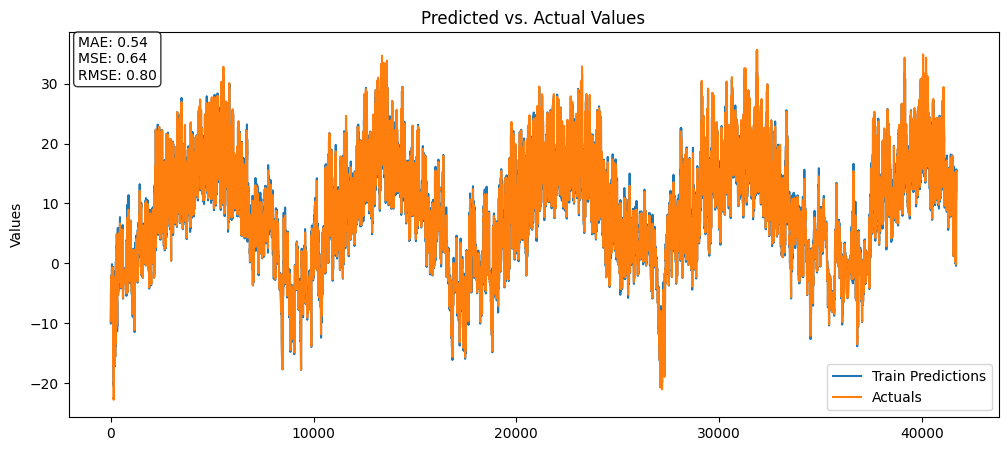

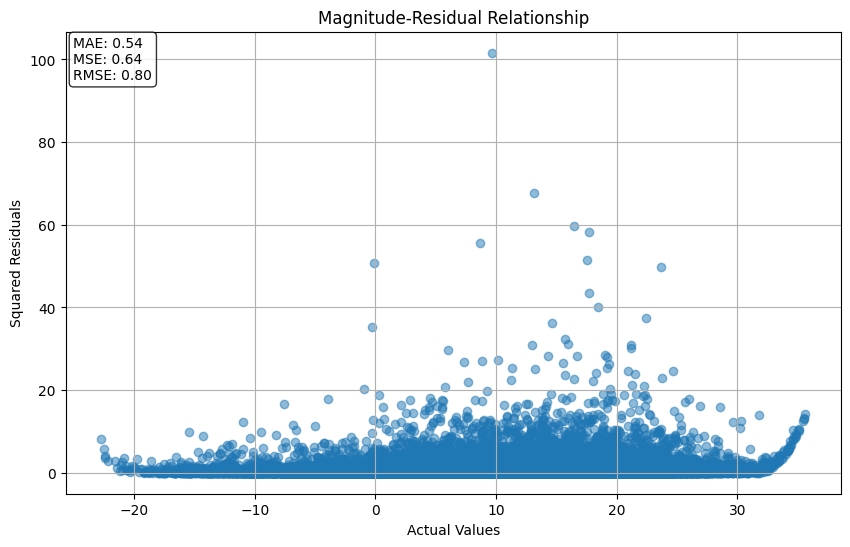

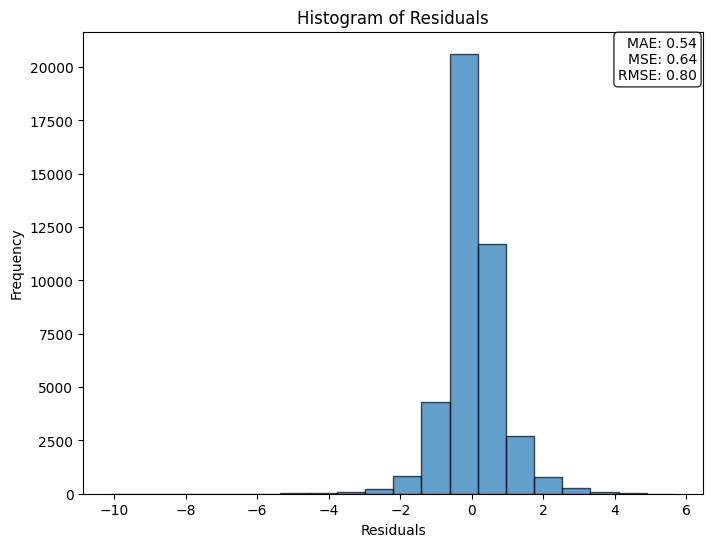

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate residuals
train_results['Residuals'] = train_results['Actuals'] - train_results['Train Predictions']

# Calculate error metrics
mae = mean_absolute_error(train_results['Actuals'], train_results['Train Predictions'])
mse = mean_squared_error(train_results['Actuals'], train_results['Train Predictions'])
rmse = np.sqrt(mse)

# Metrics for display
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}"

# Plot Predictions vs. Actuals
plt.figure(figsize=(12, 5))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Actuals')
plt.title('Predicted vs. Actual Values')
plt.ylabel('Values')
plt.legend()
plt.text(0.01, 0.99, metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Residual Plot for Magnitude-Residual Relationship
# Calculate squared residuals
train_results['Squared Residuals'] = (train_results['Actuals'] - train_results['Train Predictions'])**2
plt.figure(figsize=(10, 6))
plt.scatter(train_results['Actuals'], train_results['Squared Residuals'], alpha=0.5)
plt.title('Magnitude-Residual Relationship')
plt.xlabel('Actual Values')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.text(0.01, 0.99, metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(train_results['Residuals'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.text(0.99, 0.99, metrics_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()


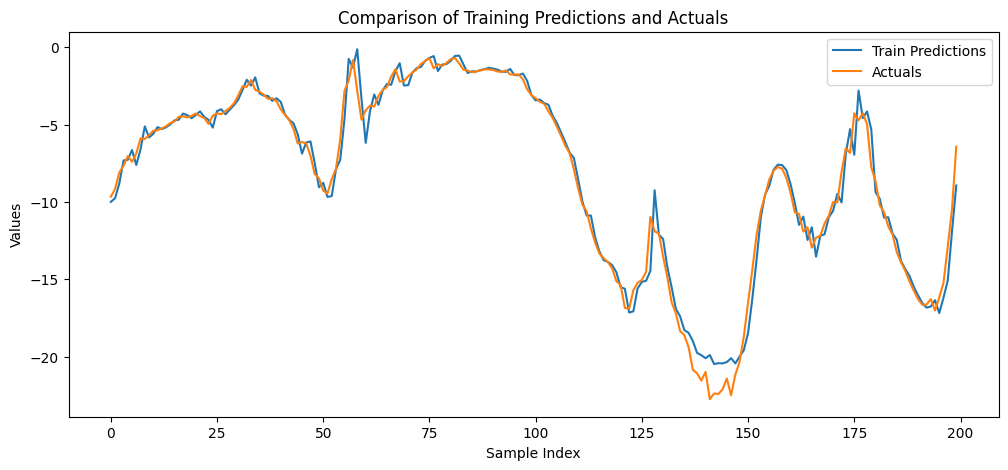

In [33]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot training predictions
plt.plot(train_results['Train Predictions'][:200], label='Train Predictions')

# Plot actual values
plt.plot(train_results['Actuals'][:200], label='Actuals')

# Adding legend to the plot
plt.legend()

# Adding titles and labels
plt.title('Comparison of Training Predictions and Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Values')

# Display the plot
plt.show()

In [34]:
test_predictions = model3.predict(X_test).flatten()

658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step


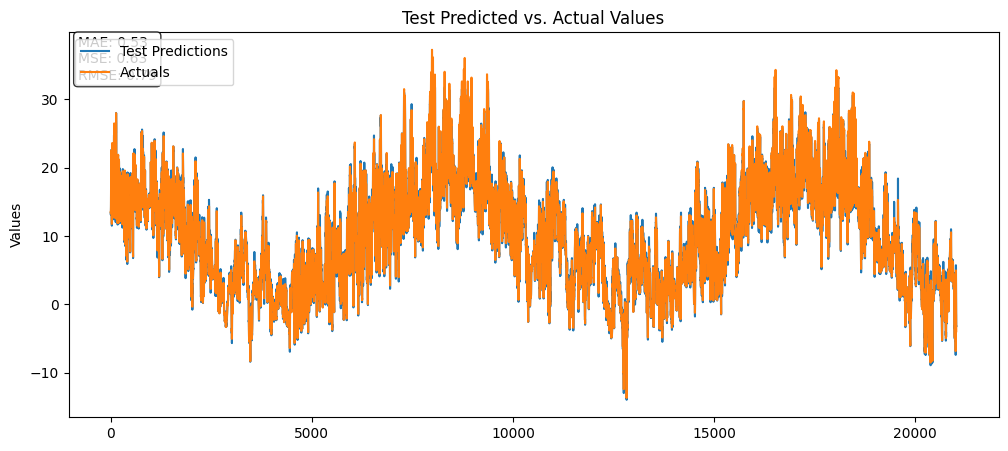

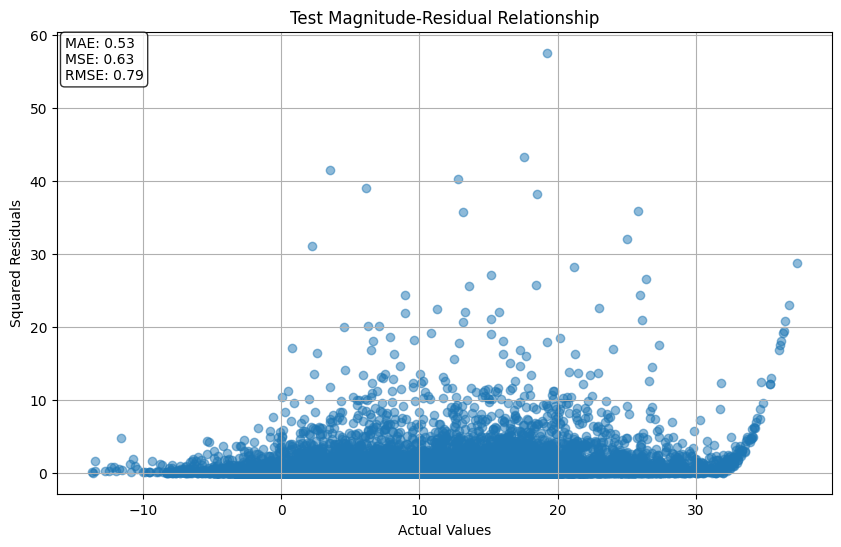

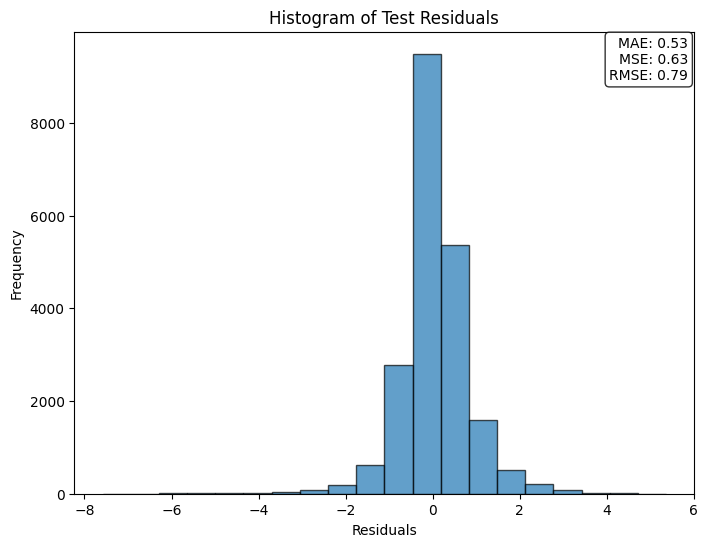

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have already loaded the model and have test_predictions and y_test available
# Create a DataFrame to hold test predictions and actual values
test_results = pd.DataFrame({
    'Test Predictions': test_predictions, 
    'Actuals': y_test
})

# Calculate residuals
test_results['Residuals'] = test_results['Actuals'] - test_results['Test Predictions']

# Calculate error metrics
test_mae = mean_absolute_error(test_results['Actuals'], test_results['Test Predictions'])
test_mse = mean_squared_error(test_results['Actuals'], test_results['Test Predictions'])
test_rmse = np.sqrt(test_mse)

# Metrics for display
test_metrics_text = f"MAE: {test_mae:.2f}\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}"

# Plot Predictions vs. Actuals for Test Data
plt.figure(figsize=(12, 5))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.title('Test Predicted vs. Actual Values')
plt.ylabel('Values')
plt.legend()
plt.text(0.01, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Residual Plot for Magnitude-Residual Relationship for Test Data
# Calculate squared residuals
test_results['Squared Residuals'] = (test_results['Actuals'] - test_results['Test Predictions'])**2
plt.figure(figsize=(10, 6))
plt.scatter(test_results['Actuals'], test_results['Squared Residuals'], alpha=0.5)
plt.title('Test Magnitude-Residual Relationship')
plt.xlabel('Actual Values')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.text(0.01, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Histogram of Residuals for Test Data
plt.figure(figsize=(8, 6))
plt.hist(test_results['Residuals'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Test Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.text(0.99, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()


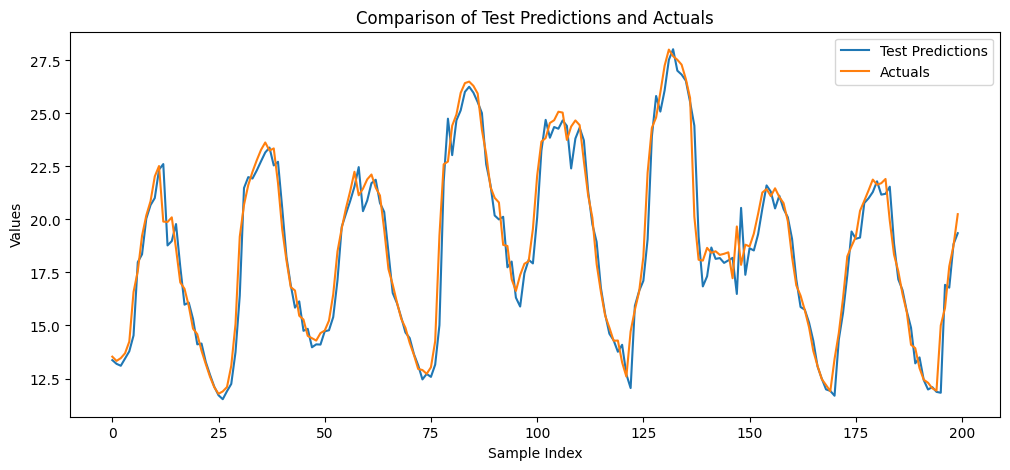

In [36]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot test predictions for the first 200 entries
plt.plot(test_results['Test Predictions'][:200], label='Test Predictions')

# Plot actual values for the first 200 entries
plt.plot(test_results['Actuals'][:200], label='Actuals')

# Adding legend to the plot
plt.legend()

# Adding titles and labels
plt.title('Comparison of Test Predictions and Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Values')

# Display the plot
plt.show()
